In [2]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
import PyImbalReg as pir
import pandas as pd
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import resreg
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score

In [3]:
df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/kpi_fuller_df.csv")

In [4]:
def label_func(faultD):
  if(faultD == 0): return 0
  elif(faultD < 500): return 1
  else: return 2



def reg_acc(md, data, test_labels):
  test_predictions = md.predict(data).flatten()
  r2 = r2_score(test_labels, test_predictions)
  rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
  mae = mean_absolute_error(test_labels, test_predictions)

  print(f'r2 score: {r2}')
  print(f'rmse score: {rmse}')
  print(f'mae score: {mae}')
  # print(f'erro medio de: {rmse} segundos')

  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])

def bin_func(faultD):
  if(faultD == 0): return 0
  else: return (faultD//500 + 1)


def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  # print('f1 score:', f1_score(y_test, predictions))
  # print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()

In [40]:
df = df.sample(frac=1)
test_data = df[:(len(df)//5)]
train_data = df[(len(df)//5):]

test_data['bin'] = test_data.fault_duration.apply(bin_func)
test_data['fault'] = test_data['fault_duration'].apply(label_func)
test_data['is_fault'] = test_data.fault.apply(lambda x: 0 if x == 0 else 1)

X_test = test_data.drop(columns=['Unnamed: 0','NE ID','endTime', 'relation','fault_duration','bin','fault','is_fault']).values
y_test_fd = test_data.fault_duration.values
y_test = test_data.fault_duration.apply(label_func).values

train_data['fault'] = train_data['fault_duration'].apply(label_func)
train_data = train_data.dropna()
train_data = train_data.drop(columns=['Unnamed: 0','NE ID','endTime','relation'])
train_data['bin'] = train_data.fault_duration.apply(bin_func)
train_data['is_fault'] = train_data.fault.apply(lambda x: 0 if x == 0 else 1)

/tmp/ipykernel_465591/150606986.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_465591/150606986.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_465591/150606986.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4

In [6]:
y = train_data.fault.values
X = train_data.drop(columns=['fault','fault_duration','is_fault','bin']).values

faults = train_data[train_data['fault_duration'] > 0]
X_fault = faults.drop(columns=['fault','fault_duration']).values
y_fault = faults.is_fault.values


In [7]:
def score(y_true, y_pred):
    rec_arr = recall_score(y_true, y_pred, average=None)
    return rec_arr[0]*0.25 + rec_arr[1]*0.25 + rec_arr[2]*0.5

In [8]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

params = {'n_estimators': 94, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1}
rf = RandomForestClassifier(**params)
rf.fit(X_smote, y_smote)


dump(rf,'rf-model-customparam.joblib')


['rf-model-customparam.joblib']

Accuracy score: 0.9461493990567473


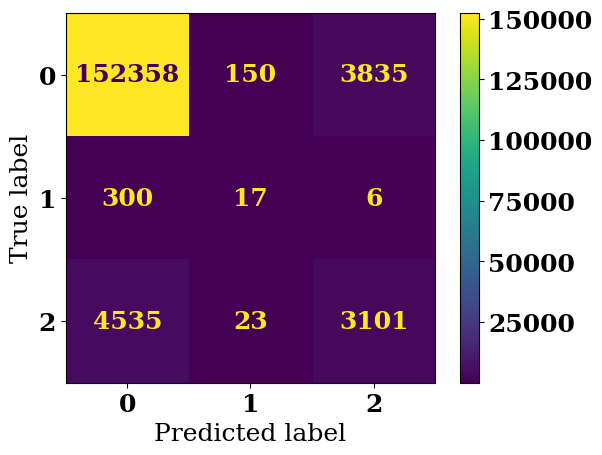

In [27]:
rf_pred = rf.predict(X_test)
show_results(y_test, rf_pred)

In [29]:
import plotly.express as px

fig = px.bar(x=train_data.drop(columns=['fault','fault_duration','is_fault','bin']).columns , y=rf.feature_importances_)
fig.show()

In [31]:
feat_imps = rf.feature_importances_

most_important = train_data.drop(columns=['fault','fault_duration','is_fault','bin']).columns[np.where(feat_imps > np.mean(feat_imps))]

In [50]:
X_most = X_smote[:, np.where(feat_imps > np.mean(feat_imps))]
X_most = X_most.reshape((X_most.shape[0], X_most.shape[2]))
X_test_most = X_test[:, np.where(feat_imps > np.mean(feat_imps))]
X_test_most = X_test_most.reshape((X_test_most.shape[0], X_test_most.shape[2]))

In [ ]:
rf_most = RandomForestClassifier(**params)
rf_most.fit(X_most, y_smote)
rf_most_pred = rf.predict(X_test_most)
show_results(y_test, rf_most_pred)

In [38]:
import numpy as np

# Exemplo de array 2D de booleanos (por exemplo, queremos manter as colunas 0 e 2)
array_booleans = np.array([True, False, True])  

# Exemplo de array 2D com algumas colunas
array = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

# Filtrando as colunas com o índice booleano
array_filtrado = array[:, array_booleans]

print(array_filtrado)


[[1 3]
 [4 6]
 [7 9]]


## PIPELINE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE,ADASYN, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

## oversample 
bds = BorderlineSMOTE()
ada = ADASYN()
kms = KMeansSMOTE(
    kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
sm = SMOTE()
ros = RandomOverSampler()

## undersample

from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler, TomekLinks
from sklearn.cluster import MiniBatchKMeans


cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
cnn = CondensedNearestNeighbour(random_state=42)  
enn = EditedNearestNeighbours()
rus = RandomUnderSampler(random_state=42)
tl = TomekLinks()